## **Introduction to Artificial Intelligence - Computer Assignment 3 - Clustering Algorithms**

## *Amin Aghakasiri*

## *Student ID : 810101381*

### *Summary and Purpose of the project*

In this project, we are supposed to put some images into groups based on their similarities using unsupervised learning ML algorithm clustering. The algorithms we use are K-means and DBSCAN that both are clustering algorithms. The dataset consists of 210 images of flowers and a csv file that contains a valid grouping for these images that we use it in order to evalute our model performance in the last part of the project. 

In [230]:
import os
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.models import Model
import numpy as np
from skimage.io import imread, imshow
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.cluster import kmeans_plusplus
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler,RobustScaler, MaxAbsScaler, Normalizer, FunctionTransformer
import sklearn
import sklearn.preprocessing
# sklearn.preprocessing.
from sklearn.metrics import silhouette_score, homogeneity_score
from keras.preprocessing.image import ImageDataGenerator
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from PIL import Image

### *Hyper-parameters*
Hyper-parameters are very important in machine learning algorithms becuase mostly we don't know the optimal solution in these problems (because of the various data that we have in these problems). So it is very important to change these parameters in order to find the better solution. Here are my hyper-parameters for this problem:
* `CLUSTERS_NUM` : Number of clusters that we want for K-means algorithm (the value of K).
* `N_INIT` : Number of times the k-means algorithm is run with different centroid seeds. The final results is the best output of n_init consecutive runs in terms of inertia (an objective function).
* `EPSILON` : The maximum distance between two samples for one to be considered as in the neighborhood of the other.
* `MINPTS` : The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.
* `PCA_DIMENSION` : The final dimension after reduction by PCA.

In [192]:
CLUSTERS_NUM = 10
N_INIT = 10
EPSILON = 0.04
MINPTS = 2
PCA_DIMENSION = 2

## *Part1 : Preprocess and Feature Extraction*

#### Question 1 : What is the purpose of feature extraction? Why reading pixels is just not enough?

Here are some reasons that we use pre trained model for feature extraction instead of reading raw pixels:

##### 1. Dimensionality Reduction : 

The feature vectors obtained from pre-trained models are typically of lower dimensions compared to raw pixel values. This reduction in dimensionality can make clustering algorithms more efficient and effective.

##### 2. High-level Feature Representation :

Pre-trained models like VGG16 have been trained on large datasets (e.g., ImageNet) to recognize a wide variety of complex patterns and features in images. They can capture intricate details that might not be evident when simply reading pixel values.

##### 3. Improved Clustering Performance :

High-level features extracted by pre-trained models can lead to more meaningful and effective clusters compared to using raw pixel values. These features often capture semantic information and object-level details, making the clustering process more robust and interpretable.

So reading pixels is not enough for 3 main reasons:

* <b> High Dimensionality </b> : Images represented as pixel values are high-dimensional, making it computationally expensive and challenging for clustering algorithms to find meaningful patterns.

* <b> Lack of Abstraction </b> : Raw pixel values lack abstraction and do not capture the hierarchical and semantic information present in images, which is crucial for tasks like clustering.

* <b> Limited Information </b> : Raw pixel values represent the color intensities of individual pixels but do not capture the semantic meaning or higher-level features of the image.

#### Question 2 : Explore about feature extraction from images and explain 3 ways of them briefly.

Machines store images in the form of a matrix of numbers. The size of this matrix depends on the number of pixels we have in any given image. We can use methods to use these pixel values as features. Here are three ways that we can extract features from images:

1. <b> Convolutional Neural Networks(CNN) </b> : 

    CNNs are generally the preferred choice for feature extraction from images because CNNs are specifically designed for processing color images and     perform more complex tasks such as image classification, object detection, or segmentation where it can extract complex and descriptive features with     any variations such as lighting conditions, scale, and other factors in the image. It is useful in situations where we want to have high accuracy     after processing our images, thus making it the most efficient way.

2. <b> Autoencoders </b> : 

    Autoencoders can be used for feature extraction in scenarios where the CNN architecture is too computationally expensive or where the amount of     labeled data is limited. In this application, the autoencoder is trained on a dataset of images and used to extract features that can be used in     downstream machine learning models. Autoencoders are generally used for unsupervised learning tasks such as anomaly detection, dimensionality     reduction, image denoising and compression and generation of new data points, where the goal is to learn a compact representation of the input data.

3. <b> Edge Features </b> :

    It can be useful for certain image processing tasks that involve detecting and analyzing edges or boundaries in an image like Object detection,     Motion detection, Image segmentation, Medical imaging and Optical character recognition(OCR). Edge features can be used to identify variations in     pixel intensity and to detect sharp transitions between regions in the image. Edge features can be effective in situations where the goal is to     perform simple image processing operations, such as edge detection or boundary extraction. 

#### Question 3 : What actions should be done in the preprocess step in order to make our data ready to be trained by the model?

Here are the steps for preprocessing part :

1. <b> Data Loading and Resizing </b> : 

    First we load the images using `load_img()` from `keras.preprocessing.image` and then convert them to arrays using the same library and `img_to_array   ()` attribute. Then, we resize the images to a consistent size that matches the input size expected by the pre-trained model ((224,224) in here).

2. <b> Data Normalization </b> : 

    Normalizing the pixel values of the images to ensure consistent scaling across all images. This is done by   `preprocess_input()` from `keras.applications.vgg16`. Actually, it will convert the input images from RGB to BGR (Blue,Green,Red), then will zero-center each color channel with respect to the ImageNet dataset, without scaling.

3. <b>  Feature Extraction </b> :

    At last, we use the pre-trained model (VGG16) to extract high-level features from the preprocessed images.




In [193]:
model = VGG16(weights = 'imagenet', include_top=False, input_shape=(256, 256,3))
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

In [194]:
def pre_extract_vgg(files):
    images = [load_img(file, target_size=(256, 256)) for file in files]
    arrays = [img_to_array(image) for image in images]
    preprocessed_arrays = [preprocess_input(arr) for arr in arrays]
    stacked_arrays = np.vstack(preprocessed_arrays)
    num_images = len(files)
    stacked_arrays = stacked_arrays.reshape((num_images, 256, 256, 3))
    features = model.predict(stacked_arrays, use_multiprocessing=True)
    features = features.reshape(num_images, -1)
    return features

In [195]:
def extract_for_all(directory):
    files = sorted(os.listdir(directory))
    image_files = [os.path.join(directory, file) for file in files[:-1]]
    features = pre_extract_vgg(image_files)
    labels = pd.read_csv(os.path.join(directory, files[-1]))
    return features, labels

In [196]:
dir = "./flower_images/"
features, df = extract_for_all(dir)
true_groups = df["label"].tolist()

7/7 [==============================] - 13s 2s/step


## *Part2 : Clustering and Dimesion Reduction Implementation*

#### Question 4 : Explain K-means and DBSCAN clustering algorithms and their pros and cons.

1. <b> K-MEANS </b>

    K-means clustering is a method of vector quantization, originally from signal processing, that aims to partition n observations into k clusters in  which each observation belongs to the cluster with the nearest mean (cluster centers or cluster centroid), serving as a prototype of the cluster. For    the algorithm, first we select k initial centroids, where k is the number of clusters. Then we assign each data point to the nearest centroid,     forming k clusters. Then we repeat this process and update the centroids until convergence.

    `Pros` : 

    * <b> Simplicity </b> : Easy to implement and understand.

    * <b> Efficiency </b> : Computationally faster than some other clustering algorithms.

    * <b> Scalability </b> : Can handle large datasets efficiently with proper initialization techniques.

    * <b> Consistent </b> : Produces tighter clusters compared to hierarchical clustering methods.

    `Cons` : 

    * <b> Sensitivity to Initialization </b> : The final clusters can be sensitive to the initial selection of centroids.

    * <b> Requires Predefined k </b> : Requires the number of clusters k to be specified in advance.

    * <b> Sensitive to Outliers </b> : Outliers can significantly affect the position and number of centroids.


2. <b> DBSCAN (Density-Based Spatial Clustering of Applications with Noise) </b>

    DBSCAN is a density-based clustering non-parametric algorithm. Given a set of points in some space, it groups together points that are closely packed   together (points with many nearby neighbors), marking as outliers points that lie alone in low-density regions (whose nearest neighbors are too far   away). DBSCAN is one of the most common, and most commonly cited, clustering algorithms. For the algorithm, first we identify core points based on    predefined distance ϵ (EPSILON) and minimum points (MinPts). Then we expand the cluster by adding neighboring points if they are also core points. At  last, we assign remaining points as noise or border points if they do not meet the criteria to be core points.

    `Pros` : 

    * <b> Noise Handling </b> : Can identify and handle noise points as outliers.

    * <b> Flexibility </b> : Can find clusters of arbitrary shapes and sizes.

    * <b> Robust </b> : Less sensitive to initialization compared to K-means.

    * <b> Automatic k </b> : Does not require the number of clusters k to be specified in advance.

    `Cons` : 

    * <b> Parameter Sensitivity </b> : Sensitivity to the parameters ϵ (maximum distance) and MinPts (minimum number of points).

    * <b> Cluster Shapes </b> : May struggle with clusters of varying densities or overlapping clusters.

    * <b> Computationally Intensive </b> : Can be slower and require more memory for large datasets.


3. <b> Comparision Between K-MEANS and DBSCAN </b>

    * <b>  Flexibility and Cluster Shape </b> : DBSCAN is more flexible and robust in identifying clusters of arbitrary shapes and sizes, whereas K-means   assumes clusters to be spherical and equally sized.

    * <b> Complexity and Understanding </b> : K-means is simpler to understand and implement compared to DBSCAN due to its straightforward centroid-based   approach.

    * <b>  Parameter Sensitivity </b> : DBSCAN requires tuning parameters ϵ and MinPts, which can be challenging and may require domain knowledge,  whereas K-means requires the number of clusters k to be specified but is less sensitive to other parameters.

    * <b>  Scalability </b> : K-means can be more scalable for large datasets with proper initialization techniques, whereas DBSCAN can be  computationally intensive and may require more memory, especially for large datasets.

#### Question 5 : How did you find the most suitable k for k-means algorithm?

I have used the `elbow finding` method in order to find the proper k for my dataset. The "elbow method" is a popular heuristic used to determine the optimal number of clusters (k) in a k-means clustering algorithm. The idea behind the elbow method is to identify the point (elbow point) where the addition of more clusters does not significantly improve the variance or inertia. For using this method, first I fitted the k-means algorithm for range (1,41) of k's. Then I calculated an objective function ("1 / homogeneity score" for my case) for each k in order to compare them. At the end, I plot the values of objective function against the number of clusters (k) and find the elbow point (where the value of objective function starts to decrease at a slower rate) which in my case, 10 was proper for k.

#### Question 6 : Compare the output of the two clustering methods.

As we can see from the plots for DBSCAN and K-means, the K-means algorithm clusters are better and more well-seperated in comparision to DBSCAN plot. Also, the scores are better and higher for k-means. There are some reasons for this that I will mention below:

1. <b> Well-Defined Clusters </b> : As we can see from the plot of PCA, our dataset is consisted of observale spherical clusters which in these case (for spherical clusters), K-means performs better than dbscan.

2. <b> Uniform Density </b> : K-means performs well when the clusters have a similar density. DBSCAN, on the other hand, requires clusters of varying densities and shapes to be specified by its parameters ϵ and MinPts. As we can see from the PCA plot, the data points have almost similart density.

3. <b> Cluster Shapes </b>: K-means assumes clusters to be spherical and equally sized, whereas DBSCAN can handle clusters of arbitrary shapes and sizes. Our clusters are closer to spherical shapes and hence k-means may produce better results.
    


#### Question 7 : What is PCA? Explain it breifly.

As the number of features or dimensions in a dataset increases, the amount of data required to obtain a statistically significant result increases exponentially. This can lead to issues such as overfitting, increased computation time, and reduced accuracy of machine learning models this is known as the curse of dimensionality problems that arise while working with high-dimensional data.  Dimensionality reduction is a type of feature extraction technique that aims to reduce the number of input features while retaining as much of the original information as possible. 


Principal Component Analysis(PCA) is a statistical procedure that uses an orthogonal transformation that converts a set of correlated variables to a set of uncorrelated variables.PCA is the most widely used tool in exploratory data analysis and in machine learning for predictive models. The main goal of Principal Component Analysis (PCA) is to reduce the dimensionality of a dataset while preserving the most important patterns or relationships between the variables without any prior knowledge of the target variables. It works on the condition that while the data in a higher dimensional space is mapped to data in a lower dimension space, the variance of the data in the lower dimensional space should be maximum. PCA is a technique for dimensionality reduction that identifies a set of orthogonal axes, called principal components, that capture the maximum variance in the data. The principal components are linear combinations of the original variables in the dataset and are ordered in decreasing order of importance. The total variance captured by all the principal components is equal to the total variance in the original dataset. The first principal component captures the most variation in the data, but the second principal component captures the maximum variance that is orthogonal to the first principal component, and so on. 


Principal Component Analysis can be used for a variety of purposes, including data visualization, feature selection, and data compression. In data visualization, PCA can be used to plot high-dimensional data in two or three dimensions, making it easier to interpret. In feature selection, PCA can be used to identify the most important variables in a dataset. In data compression, PCA can be used to reduce the size of a dataset without losing important information.

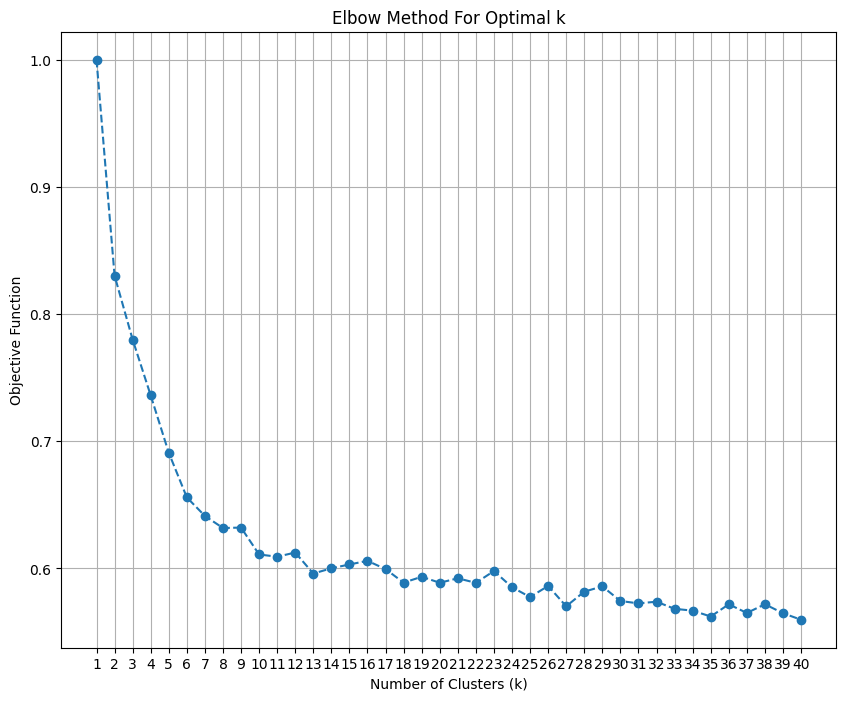

In [197]:
kmeans = KMeans(n_clusters=CLUSTERS_NUM, n_init=N_INIT)
scaler = Normalizer()
scaled_features = scaler.fit_transform(features)
pca_homo = PCA(n_components=5)
features_pca_homo = pca_homo.fit_transform(scaled_features)
objective_function_values = []
k_values = range(1, 41)
# Compute objective function (1 / homogeneity score) for each k
for k in k_values:
    kmeans = KMeans(n_clusters=k, n_init=N_INIT)
    a = kmeans.fit_predict(features_pca_homo)
    temp = homogeneity_score(true_groups, a)
    objective_function_values.append(1/(temp+1))

plt.figure(figsize=(10, 8))
plt.plot(k_values, objective_function_values, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Objective Function')
plt.title('Elbow Method For Optimal k')
plt.xticks(k_values)
plt.grid(True)
plt.show()

In [224]:
def calc_scores_kmeans(dimension):
    kmeans = KMeans(n_clusters=CLUSTERS_NUM, n_init=N_INIT)
    scaler = Normalizer()
    scaled_features = scaler.fit_transform(features)
    pca_s = PCA(n_components=dimension)
    pca_homo = PCA(n_components=dimension+4)
    features_pca_s = pca_s.fit_transform(scaled_features)
    features_pca_homo = pca_homo.fit_transform(scaled_features)
    number_iters = 10
    silhouette_scores = []
    homogeneity_scores = []
    print(f"Scores for dimension number as {dimension} for PCA")
    
    for i in range(number_iters):
        groups_s = kmeans.fit_predict(features_pca_s)
        groups_homo = kmeans.fit_predict(features_pca_homo)
        silhouette_s = silhouette_score(features_pca_s, groups_s)
        homogeneity_s = homogeneity_score(true_groups, groups_homo)
        print(f"Silhouette Score for clusters number {i+1}: {silhouette_s}")
        print(f"Homogeneity Score for clusters number {i+1}: {homogeneity_s}")
        print("----")
        silhouette_scores.append(silhouette_s)
        homogeneity_scores.append(homogeneity_s)

    avg_silhouette_score = np.mean(silhouette_scores)
    avg_homogeneity_score = np.mean(homogeneity_scores)
    print(f"Average Silhouette Score after {number_iters} runs: {avg_silhouette_score}")
    print(f"Homogeneity Score after {number_iters} runs: {avg_homogeneity_score}")
    groups_kmeans = kmeans.fit_predict(features_pca_homo)
    pcaaa = PCA(n_components=dimension+1)
    features_pcaa = pcaaa.fit_transform(scaled_features)
    return features_pcaa, groups_kmeans

In [227]:
pca_kmeans, groups_kmeans = calc_scores_kmeans(1)

Scores for dimension number as 1 for PCA
Silhouette Score for clusters number 1: 0.5613024234771729
Homogeneity Score for clusters number 1: 0.6004936192496543
----
Silhouette Score for clusters number 2: 0.5536823272705078
Homogeneity Score for clusters number 2: 0.6223699520179762
----
Silhouette Score for clusters number 3: 0.5676138401031494
Homogeneity Score for clusters number 3: 0.6086229529782621
----
Silhouette Score for clusters number 4: 0.5535070300102234
Homogeneity Score for clusters number 4: 0.5940806893635867
----
Silhouette Score for clusters number 5: 0.5617458820343018
Homogeneity Score for clusters number 5: 0.5988658637516605
----
Silhouette Score for clusters number 6: 0.5578276515007019
Homogeneity Score for clusters number 6: 0.596542816152318
----
Silhouette Score for clusters number 7: 0.5595977902412415
Homogeneity Score for clusters number 7: 0.6081014238787853
----
Silhouette Score for clusters number 8: 0.5536823272705078
Homogeneity Score for clusters nu

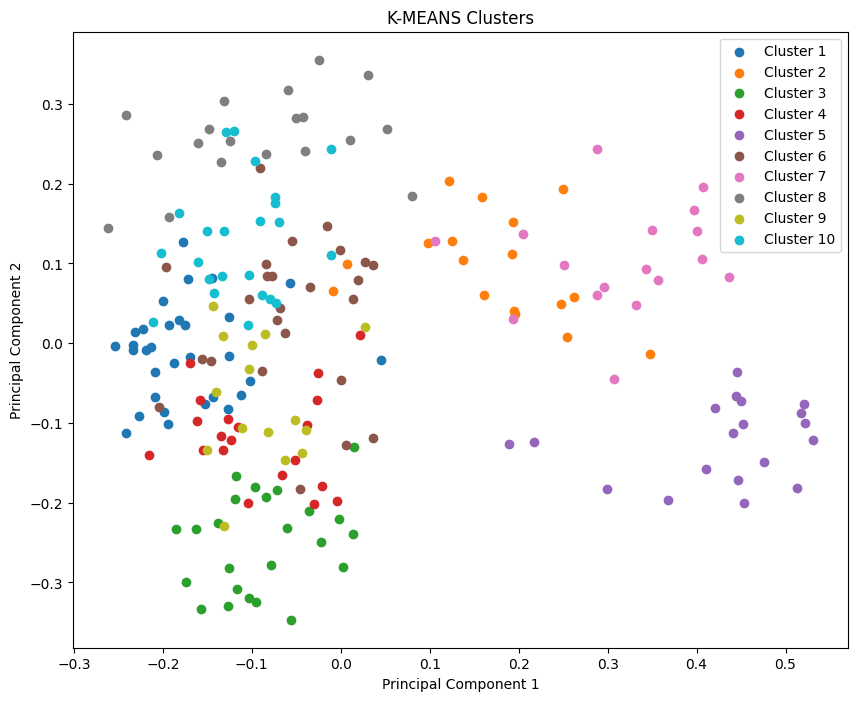

In [262]:
col = plt.cm.tab10(np.linspace(0, 1, CLUSTERS_NUM))
plt.figure(figsize=(10, 8))
for i in range(CLUSTERS_NUM):
    plt.scatter(pca_kmeans[groups_kmeans == i, 0], pca_kmeans[groups_kmeans == i, 1], c=[col[i]], label=f'Cluster {i+1}', alpha=1)

plt.title('K-MEANS Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Images For Cluster 4


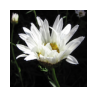

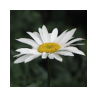

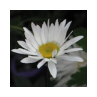

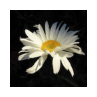

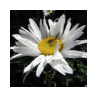

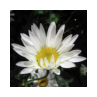

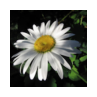

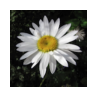

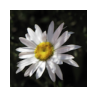

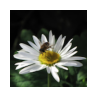

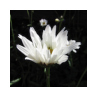

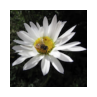

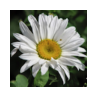

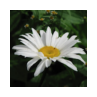

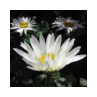

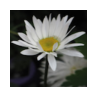

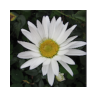

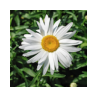

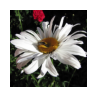

In [254]:
a = 4
indices = [index for index, value in enumerate(groups_kmeans) if value == a]

print(f"Images For Cluster {a}")
for idx in indices:
    temp = idx+1
    num = str(temp)
    if temp < 10:
        png = "000" + num + ".png"
    elif temp < 100:
        png = "00" + num + ".png"
    else:
        png = "0" + num + ".png"
    path = "./flower_images/" + png
    image = Image.open(path)
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

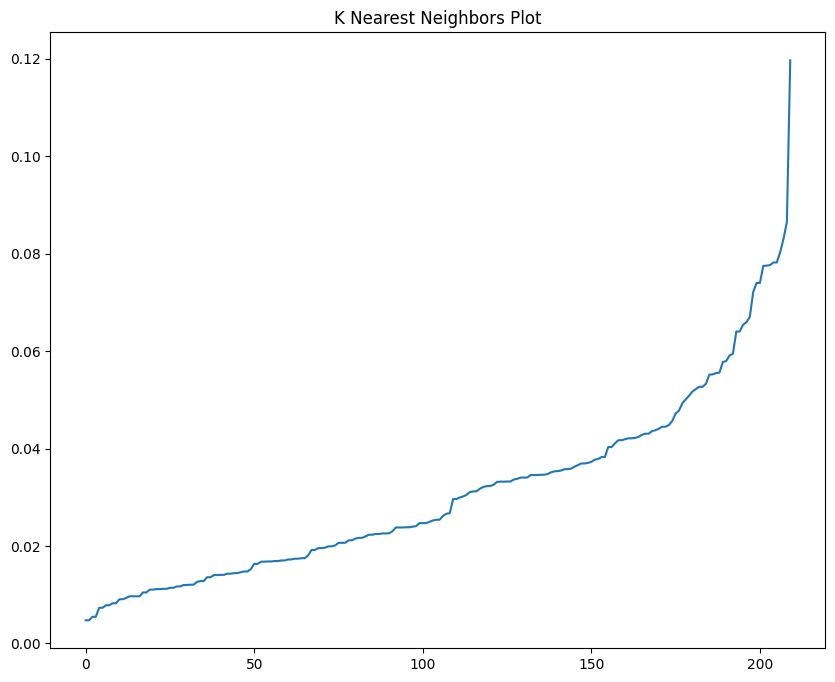

In [261]:
scalerr = Normalizer()
scaled_featuress = scalerr.fit_transform(features)
pca_homo = PCA(n_components=2)
features_pca = pca_homo.fit_transform(scaled_features)
features_pca = np.log2(features_pca+1)


nn = NearestNeighbors(n_neighbors=10).fit(features_pca)
distances, indices = nn.kneighbors(features_pca)
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.figure(figsize=(10,8))
plt.title('K Nearest Neighbors Plot')
plt.plot(distances)

In [258]:
min_sampless = range(1,20)
epss = np.arange(0.001,0.13,0.0005)
output = []
for ms in min_sampless:
    for ep in epss:
        labelss = DBSCAN(min_samples=ms, eps=ep).fit_predict(features_pca)
        if all(element == labelss[0] for element in labelss):
            continue
        if max(labelss) >= 20 or max(labelss) <= 2:
            continue
        sil = silhouette_score(features_pca, labelss)
        homo = homogeneity_score(true_groups, labelss)
        temp = (sil*homo) / (sil+homo)
        if sil <= 0:
            continue
        output.append((ms,ep,sil,homo,labelss,temp))

a = sorted(output, key=lambda x:x[-1])
min_sampless, epss, silhouette_sc, homogeneity_sc, groups_dbscan, score = sorted(output, key=lambda x:x[-1])[-1]
print(groups_dbscan)
print(f"Homogeneity Score : {homogeneity_sc}")
print(f"Silhouette Score : {silhouette_sc}")

[ 0  0  1  0  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0  0  1  2  1 -1
  0  0  1  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  1  0  0  2  1  0
  0  0  0  2  1  0  0  0  3  0  0  0  1  0  1  1  0  3  0  0  0  2  0  0
  0  0  0  0  0  0  0  0  0  2  0  0  0  3  1  2  0  2  0  0  3  1  0  0
  0  0  0  0  0  1  2  0  0  1 -1  0  0  0  0  2  1  0  3  0  0  0  0  0
  3  1 -1  3  0  0  1  0  0  0  0  1  0  2  0  0  0  0  1  2  0  2  0  0
  1  1  0  2  0  0  1 -1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  1  0
  0  0  0  0  0  0  0  3  0  2  1  1  0  0  0  0  0  0  0  0  0  1  2  0
  0  0  0  0  0  3  0 -1  0  0  0  0  2  0  0  2  0  0]
Homogeneity Score : 0.307251745056422
Silhouette Score : 0.3259575366973877


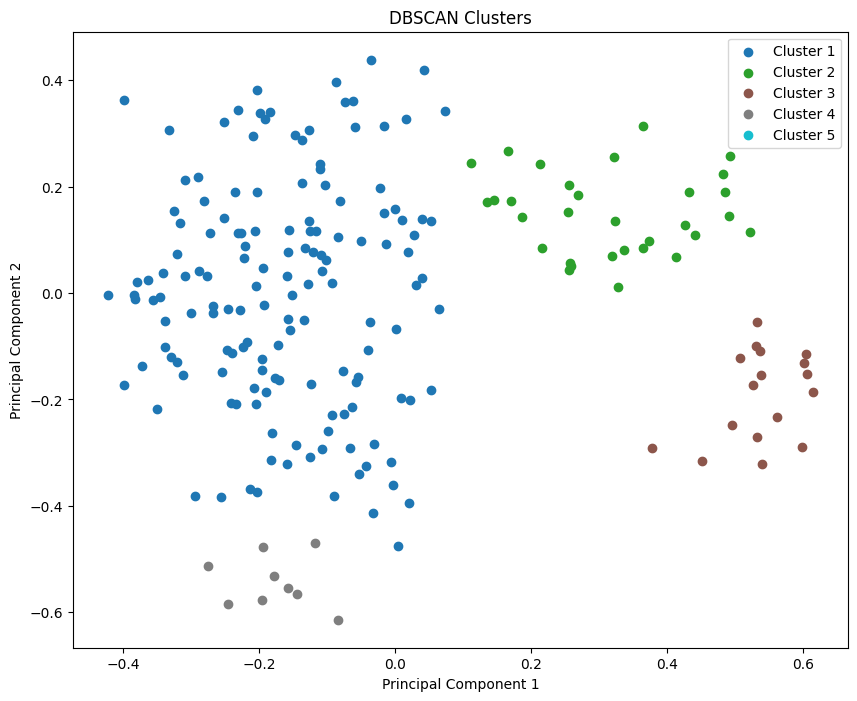

In [260]:
n_clusters = len(np.unique(groups_dbscan))
colors = plt.cm.tab10(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(10, 8))
for i in range(n_clusters):
    plt.scatter(features_pca[groups_dbscan == i, 0], features_pca[groups_dbscan == i, 1], c=[colors[i]], label=f'Cluster {i+1}', alpha=1)

plt.title('DBSCAN Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

Images For Cluster 1


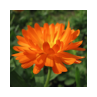

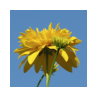

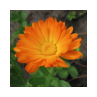

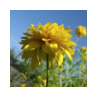

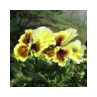

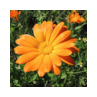

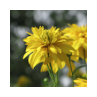

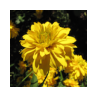

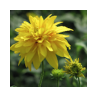

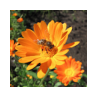

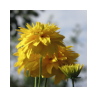

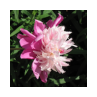

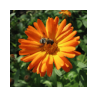

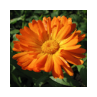

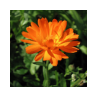

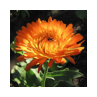

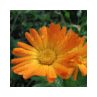

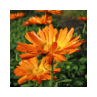

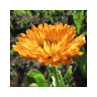

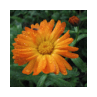

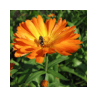

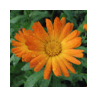

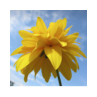

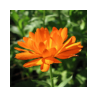

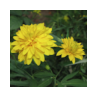

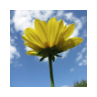

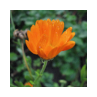

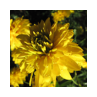

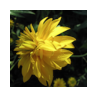

In [247]:
a = 1
indices = [index for index, value in enumerate(groups_dbscan) if value == a]

print(f"Images For Cluster {a}")
for idx in indices:
    temp = idx+1
    num = str(temp)
    if temp < 10:
        png = "000" + num + ".png"
    elif temp < 100:
        png = "00" + num + ".png"
    else:
        png = "0" + num + ".png"
    path = "./flower_images/" + png
    image = Image.open(path)
    plt.figure(figsize=(1, 1))
    plt.imshow(image)
    plt.axis('off')  # Turn off axis
    plt.show()

## *Part3 : Evaluation and Analysis*


#### Question 8 : Explain about silhouette score and homogeneity score and they are calculated.

1. **Silhouette Score**

    Silhouette Score is a tool for assessing the appropriateness of clustering results by providing a quantitative measure  of how well-defined and distinct the clusters are. The Silhouette Score quantifies how well a data point fits into its   assigned cluster and how distinct it is from other clusters. It measures the cohesion and separation of data points   within clusters and helps determine whether the clusters are well-separated and internally homogeneous. Means that the    silhouette score measures the similarity of an object to its own cluster compared to other clusters. The score ranges  from -1 to 1. Here are the steps for calculating it:

    For each data point $i\in C_{I}$  (data point i in the cluster $C_{I}$) and $C_{J}$ which $I\neq J$ we have:

    $$a(i) = \frac{1}{|C_{I}|-1}\sum_{j\in C_{i},i\neq j}^{}d(i,j)$$

    $$b(i) = \min\frac{1}{|C_{i}|}\sum_{j\in C_{J}}^{}d(i,j)$$

    $$ s(i) =\frac{b(i)-a(i)}{\max(a(i),b(i))} $$

    which $a(i)$ is the mean distance between i and all other data points in the same cluster and $b(i)$ is the smallest mean distance of i to all points in any other cluster (i.e., in any cluster of which i is not a member).At last, the final score is the average of silhouette scores for all points. A negative score indicates that the data point is likely assigned to the wrong cluster, as its distance to its assigned cluster’s points is greater than its distance to the nearest neighboring cluster’s points. A score close to 0 implies that the data point is on or very close to the decision boundary between two clusters. It indicates that the clustering is not well-defined and can be ambiguous. A positive score indicates that the data point is appropriately clustered, and its distance to its assigned cluster’s points is smaller than its distance to the nearest neighboring cluster’s points. A score close to +1 suggests that the data point is well-clustered and distinctly separated from other clusters. It is a strong indication of a meaningful clustering result.



2. **Homogeneity Score**

    The homogeneity score is a metric used to evaluate the homogeneity of the clusters formed by a clustering algorithm. It measures how well each cluster contains only members of a single class. The homogeneity score ranges from 0 to 1, where a higher score indicates better homogeneity. Here are the steps for calculating it:

    The homogeneity score $H(C,K)$ is defined as : 

    $$H(C,K) = 1 - \frac{H(C|K)}{H(C)}$$

    That H(C) is the entropy of the class labels and H(C|K) is the conditional entropy of the class labels given the cluster assignments.

    $$H(C) = -\sum_{i=1}^{n}p_ilog(p_i)$$

    $$H(C|K) = -\sum_{i=1}^{n}\sum_{j=1}^{m}p_{ij}log(\frac{p_{ij}}{p_i})$$


    That n is the number of classes, m is the number of clusters, $p_i$ is the probability of class i occurring and $p_{ij}$ is the probability of class i occurring in cluster j.
    
    A homogeneity score of 1.0 indicates perfect homogeneity, meaning each cluster contains only data points from a single class. A lower homogeneity score indicates that the clusters contain mixed classes.


#### Question 9 : Report the results for each clustering algorithm using these two scales.

The results are shown in the previous parts above.

#### Question 10 : Suggest some approaches for making the models better.

Improving the performance of KMeans and DBSCAN clustering algorithms involves various strategies, from preprocessing the data to fine-tuning algorithm parameters. Here are some suggestions for both:

##### KMeans

1. **Feature Selection**: Removing irrelevant or redundant features is important. K-means can perform poorly if the dataset contains features that are not useful for clustering.

2. **Feature Scaling**: KMeans is sensitive to the scale of the data. Features on larger scales can dominate the algorithm's behavior. Standardizing or normalizing our data ensures that each feature contributes equally to the distance computations.

3. **Handling Non-spherical Data**: KMeans assumes that clusters are spherical and equally sized, which is not always the case. Sometimes transforming the data (e.g., using PCA for dimensionality reduction), can lead to more spherical clusters.

4. **Choosing the Right Number of Clusters**: Using methods like the elbow Method to determine an appropriate number of clusters is beneficial.

5. **Initializing Centroids**: The default method in scikit-learn's K-means is 'k-means++', which is generally better than random initialization. However, running the algorithm multiple times with different initializations and choosing the best result can also be beneficial.

##### DBSCAN

1. **Data Scaling**: Like KMeans, DBSCAN is sensitive to the scale of the data. Normalizing or standardizing our features can lead to better clustering results.

2. **Dealing with High Dimensionality**: In high dimensions, distance metrics become less useful (curse of dimensionality). Dimensionality reduction techniques like PCA or t-SNE might help before applying DBSCAN.

3. **Parameter Tuning**: Eps and min_samples are crucial parameters. We can use a k-distance plot to choose an appropriate eps value. The min_samples can be set based on domain knowledge or experimental tuning. Also, the choice of distance metric (Euclidean, Manhattan, etc.) can significantly affect the results.

4. **Experimenting with Different Parameters**: We should try different values for eps and min_samples in order to find the best answer for our dataset.

5. **Handling Noise**: DBSCAN can identify outliers as noise. Analyzing these noise points can provide insights and help in adjusting parameters if too many points are classified as noise.

### Other approches to make the models better

1. **Visualizing Results**: Visualizing our clustering results using techniques like scatter plots or t-SNE is useful. This can give us insights into the clusters and how well the algorithm is performing.

2. **Understanding our Data**: Knowing the characteristics of our dataset is very important. Clustering is an exploratory technique, and its success often relies on how well the data and its features represent the problem we are trying to solve.


## *Conclusion*


In this project, we aimed to cluster a dataset of flower images using the K-means and DBSCAN algorithms and visualize the results using PCA. We utilized VGG16 for feature extraction and preprocessing of the images. Despite experimenting with various preprocessing techniques, the silhouette score remained suboptimal. We then visualized the clustered images, focusing on displaying those belonging to a specific cluster. Although the clustering improved the homogeneity score, achieving an optimal silhouette score proved challenging. Further exploration of preprocessing and feature extraction methods and working with different hyper-parameters could enhance the clustering performance.

#### Resources:

https://www.educative.io/answers/what-is-silhouette-score#:~:text=Silhouette%20Score%20is%20a%20tool,it%20is%20from%20other%20clusters.

https://www.youtube.com/watch?v=_jg1UFoef1c

https://en.wikipedia.org/wiki/Silhouette_(clustering)

https://lightning.ai/docs/torchmetrics/stable/clustering/homogeneity_score.html

https://www.youtube.com/watch?v=RDZUdRSDOok

https://www.youtube.com/watch?v=-p354tQsKrs

https://medium.com/@okanyenigun/dbscan-demystified-understanding-how-this-parameter-free-algorithm-works-89e03d7d7ab#:~:text=DBSCAN%20works%20by%20partitioning%20the,are%20considered%20outliers%20or%20noise.

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

https://towardsdatascience.com/how-to-cluster-images-based-on-visual-similarity-cd6e7209fe34

https://medium.com/@mohitjavali/10-ways-to-extract-features-from-an-image-f44c8e9b0fbf

https://www.analyticsvidhya.com/blog/2019/08/3-techniques-extract-features-from-image-data-machine-learning-python/

https://en.wikipedia.org/wiki/DBSCAN

https://www.geeksforgeeks.org/principal-component-analysis-pca/

And lots of other searches and youtube videos!